# This script is part of the HRVM Simulation-Optimization Framework used in the study:
# "Reducing Substance Use-Related Harms: A Simulation-Optimization Framework for the Design and Evaluation of Harm Reduction Vending Machines."

## Version 6.0.1 - All rights reserved.

## For further info please contact Rey Zafarnejad, PhD.


## Part 1: the ABM

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import collections        
import pickle
import time
import networkx as nx
from scipy.spatial import distance
from itertools import combinations
from multiprocessing import Pool
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [13]:
# The Decision Varaible: vi (number [volume] of item i - only the box/package is counted)
SIM_duration = 90


VM_items = ['naloxone_kit', 'FTS', 'injection_kits']

# a[['HIV_New_Cases', 'HCV_New_Cases', 'OD_experienced', 'OD_deceased']]
DALYs = np.array([601.5/100000, 184.5/100000, 2312/200000, 2624/200000]).reshape(1, -1)

COSTs = np.array([31756, 2442, 272535, 14227000]).reshape(1, -1) * (90/365)
COSTs_VM_items = np.array([44.99/2, 2.5, 0.15]).reshape(1, -1)
Fixed_COSTs = (2989.38 + 600 + 1800 + 180 + 150) * (90/365)                 #2,989.38 is the 10 year rdiscounted for the fixed cost of 24000 + 1500 of purchasing and installation 

Tot_Vol = 100

Substances = ['heroin']
substances_incidence = np.array([1]) #Reported opioid/stimulant use in the past 3 days - 2019 

Use_type = ['inject'] #None

OD_Status = ['OD', 'OD_saved', 'OD_deceased', 'OD_experienced', 'already_deceased'] #True, False

initial_backpack = np.zeros((len(VM_items),))

#OD status = None, OD, already_dicaesed, OD_diceased

# time = days
#Overall, a previous meta-analysis indicated that one-fifth of PWID have had an overdose in the preceding 12 months
#https://ascpjournal.biomedcentral.com/articles/10.1186/s13722-022-00325-2#:~:text=Overall%2C%20a%20previous%20meta%2Danalysis,including%20possible%20death%20%5B8%5D.
OD_incidence = 0.00145
OD_repeat_coef = 4

#67·6% (62·6–72·4) were found to be frequent injecting drug users. Lancet injection drug use paper
WTT_coef = 0.676
employment_WTT_coef = 1
insurance_WTT_coef = 1
injection_demand_coef = 1
drugtype_demand_coef = 1

#Most events (95%) were successfully reversed, with 78% using ≥ 2 doses and 30% using ≥ 3 doses of Narcan® Nasal Spray.
naloxone_success_rate = 0.95

item_limit = 1 # limit of 1 per item

HCV_initial_prevalence = 0.4 
HIV_initial_prevalence = 0.07

#Modeling studies of HCV transmission in PWID have used estimated injection-related transmission probabilities ranging from 1% to 3% [6–9], but these were not derived from observed data in PWID.
#and can only reach a maximum of 10% when the patient is positive for hepatitis C RNA
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7162618/#:~:text=Modeling%20studies%20of%20HCV%20transmission,from%20observed%20data%20in%20PWID.
HCV_spread_prob = 0.018
#What is the percentage of getting HIV from a needlestick? For people who inject drugs, the risk of transmission per injection from a contaminated needle has been estimated to be between 0.7% and 0.8%.
#https://www.catie.ca/sites/default/files/HIV-TRANSMISSION-RISK-EN.pdf
#The average risk for infection after a needlestick or cut exposure to HCV- infected blood is approximately 1.8%.
HIV_spread_prob = 0.006
#according to the NYU paper based on which WTT is defined
willingness_touse_SIF = 0.86
# In both locations, high FTS utilization was reported (70% in Baltimore; 77% in Delaware) - Ju NyeongPark et al, 2021
FTS_utaliztion_rate = 0.735
#https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2754249
fentanyl_adultrationn_rate = 0.692
#Evaluation of fentanyl test strip distribution in two Mid-Atlantic syringe services programs
FTS_positive_adherence = 1 - (0.674*123 + 0.386*102)/(123+102)
OD_death_rate = 0.90
OD_ED_visit_prob = 0.690


treatment_success_prob = 0  #was 0.01 before

########################
                       #
np.random.seed(1376)   #
random.seed(1376*2)    #
                       #
########################

needle_flag_count = 0

FTS_soursed_from_somewhereelse = 0.454
prob_reuse_insteadof_share = 0.429
clean_needle_likelihood = 0.623

In [14]:
import numpy as np

class Agent:
    
    def __init__ (self, agent_id = 0, location = (0,0), living_status = True, age = 0, sex = 0, race = 0, ethnicity = 0, employment_status = 0, insurance_status = 0, 
                  caregiver_status = 0, substance = 0, use_type = 0, OD_status = None, HIV_status = None, HCV_status = None, backpack = initial_backpack.copy(), time = 0):
        
        self.agent_id = agent_id
        self.living_status = living_status #True or False
        
        self.age = age
        self.sex = sex
        self.race = race
        self.ethnicity = ethnicity
        self.employment_status = employment_status
        self.insurance_status = insurance_status
        self.caregiver_status = caregiver_status
        
        self.substance = substance
        self.use_type = use_type
        
        self.OD_status = OD_status
        self.HIV_status = HIV_status
        self.HCV_status = HCV_status
        
        self.needle_flag = 0
        self.needle_flag_count = 0
            
################################################# based on OD status:

        self.OD_flag = False
        
        self.location = location
            
#        if self.substance ==  & self.use_type ==       #different OD incidence for different drugs and use types
        self.OD_incidence = OD_incidence
            
        self.backpack = backpack.copy()
        
        self.treatment_referral = False
        
        self.time = time
        
        self.health_log = np.empty((0,7))
        
        
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------        
        
    def __repr__(self):
        return ('{}, {}, {}, {}, {}, {}'.format(self.agent_id, self.location, self.substance, self.use_type, self.OD_status, self.needle_flag))

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
              
    def get_agent_health_log(self, time):
        self.time = time
        
        #################################################### D A L Y ####################################################

#        if self.living_status:
#            if (self.OD_status == 'OD_saved') | (self.OD_status == 'OD_experienced'):
#                self.daily_DALY = self.daily_DALY + 0.5/365
#            if 
#        if (self.OD_status == 'OD_deceased') | (self.OD_status == 'already_deceased'):
#            self.daily_DALY = 1/365
            
#        if (self.HIV_status == 'Positive':
#            self.daily_DALY = 1/365
            
    
        new_row = np.array([time, self.agent_id, self.living_status, self.OD_status, self.HIV_status , self.HCV_status, self.needle_flag]).reshape(1,-1)
        self.health_log = np.vstack((self.health_log, new_row))


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Walking distance (miles) for active users: Allen et al. (2015) 2.47 (SD = 2.10)
# Up to a maximum of 3 miles Czarina N. Behrends et al - 2019 (NYU paper with WTT data)

    def get_daily_demand(self, VM, WTT_coef=1):

        x = distance.euclidean(self.location, VM.location)

        if x <= 0.25:  # miles / considering both walking and driving on average
            WTT = 1
        elif (x > 0.25) and (x <= 0.5):
            WTT = 0.84
        elif (x > 0.5) and (x <= 0.75):
            WTT = 0.716
        elif (x > 0.75) and (x <= 1):
            WTT = 0.585
        elif (x > 1) and (x <= 1.5):
            WTT = 0.463
        elif (x > 1.5) and (x <= 2):
            WTT = 0.298
        elif (x > 2) and (x <= 2.5):
            WTT = 0.185
        elif (x > 2.5) and (x <= 3):
            WTT = 0.095
        else:
            WTT = 0

        if not self.employment_status:
            WTT = np.min((WTT, WTT * employment_WTT_coef))
        if not self.insurance_status:
            WTT = np.min((WTT, WTT * insurance_WTT_coef))

#        WTT = WTT * WTT_coef

        demand_table = np.zeros((3,), dtype=np.float32)
        demand_table[:] = [WTT, WTT*FTS_utaliztion_rate, WTT*willingness_touse_SIF]

#        if self.OD_flag:
#            demand_table[0] = np.min((WTT * OD_naloxone_coef, 1))

# for i = 0 (Naloxone), 1 (FTS), 2 (injection kit)

###################################### CLEAN NEEDLE PROBABIITY ######################################

############ i = 0 ############
        kg = np.random.random()
        if ((kg <= demand_table[0]) and (self.backpack[0] < item_limit)):
            demand_table[0] = 2
        else: 
            demand_table[0] = 0
############ i = 1 ############   
        pg = np.random.random()
        if ((pg <= demand_table[1]) and (self.backpack[1] < item_limit)): 
            demand_table[1] = 10
        else:
            demand_table[1] = 0
############ i = 2 ############    
        if (self.backpack[2] < item_limit) :                         #if they don't have anything in hand so they will demand anyway   
            gh = np.random.random()
            if gh > clean_needle_likelihood:            
                mh = np.random.random()                              #if they will somehow DON'T end up with a clean needle, so they demand from the VM: 
                if mh <= demand_table[2]:                            #if they are willing to travel to the VM:
                    demand_table[2] = 10
                else:                                                #if they are not willing to travel but will eventually get clean needles:
                    demand_table[2] = 0   # was None before                                          
            else: #if <= clean_needle_likelihood                                      #they will be given a pack of 10 syringes! 
                self.backpack[2] = 10
                demand_table[2] = 0      # didn't exist before
        else:
            demand_table[2] = 0

        return demand_table


In [15]:
class Vending_Machine:
    
    def __init__ (self, VM_id, compartments_table, time):
        
        self.VM_id = VM_id
        self.compartments_table = compartments_table
        
        self.location = np.array([0,0])
            
        self.time = time
        
        self.log = np.empty((0, 4))
        
        self.shortage_fulfilled_demand_table = np.zeros((3, 2))
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    def __repr__(self):
        return ('{}, {}'.format(self.VM_id, self.compartments_table))
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    def get_VM_inventory_log(self, time):
        self.time = time

        new_row = np.array([self.time, self.VM_id, self.compartments_table, self.shortage_fulfilled_demand_table])
        self.log = np.vstack((self.log, new_row))


In [16]:
class Supply_chain:
    
    def __init__(self, agents, VM, time=0):
        self.VM = VM
        self.agents = agents
        self.time = time
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------        
    def get_total_demand(self, agents, VM):
        individual_demand_list = []
        for agent in agents:
            if agent.living_status:
                individual_demand_list.append(agent.get_daily_demand(VM))
        total_daily_demand = sum(individual_demand_list)
        return total_daily_demand
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------        
    def VM_session(self, time):
        VM = self.VM
        agents = self.agents
        
        np.random.shuffle(agents)
        
        for agent in agents:
            if agent.living_status:
                demand_table = agent.get_daily_demand(VM)
                
                if np.any(demand_table[demand_table[:] > 0]):
                    if np.random.random() <= treatment_success_prob:
                        agent.living_status = False
                        agent.treatment_referral = True
                        
                individual_fulfilled_demand = demand_table.copy()

                VM.compartments_table[np.isnan(VM.compartments_table)] = 0
                VM.shortage_fulfilled_demand_table[np.isnan(VM.shortage_fulfilled_demand_table)] = 0
                
                for i in range(3):
                    if demand_table[i] <= VM.compartments_table[i,0]:                                              #if demand meetable!
                        VM.shortage_fulfilled_demand_table[i,0] += demand_table[i]                                 #fulfilled + demand
                        VM.shortage_fulfilled_demand_table[i,1] += 0                                               #shortage + demand
                    else:                                                                                          #if not,
                        VM.shortage_fulfilled_demand_table[i,0] += VM.compartments_table[i,0]                      #fulfill as many as there is (compartment_table inventory)
                        individual_fulfilled_demand[i] = VM.compartments_table[i,0]                                #update the met demand table
                        VM.shortage_fulfilled_demand_table[i,1] += (demand_table[i] - VM.compartments_table[i,0])  #shortage = total_individual_demand - inventory (total_individual_demand > inventory)
                
                VM.compartments_table[:,0] -= demand_table[:]                                                      #update the inventory
                VM.compartments_table[VM.compartments_table < 0] = 0                                               #put zero wherever there is shortage
                
                agent.backpack[:] += individual_fulfilled_demand[:]                                                #update agent backpack

        return agents, VM
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------            
    def VM_restock(self, VM, time):
        VM = self.VM
        VM.compartments_table[:,0] = np.where(VM.compartments_table[:,0] <= VM.compartments_table[:,1], VM.compartments_table[:,1], VM.compartments_table[:,0])
        return VM

In [17]:
class Social_Network:
    
    def __init__ (self, agents):
        
        self.size = len(agents)
        
        self.drug_users = []
        self.non_drug_users = []
#        for agent in agents:
#            if agent.substance == 'None':
#                self.non_drug_users.append(agent)
#            else:
#                self.drug_users.append(agent)
        
        self.PWIDs = agents
#        for agent in self.drug_users:
#            if agent.use_type == 'inject':
#                self.PWIDs.append(agent)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------        
    
    def get_injection_network(self):
        
#Based on   et. al, 2018 - Supplementary material
# hh = household, 1/2/5 = 1/2/5 member(s)
        hh_1_prob = 0.26 #[0.13 - 0.38]
        hh_2_prob = 0.24 #[0.10 - 0.37]
        hh_5_prob = 0.50 #[0.37 - 0.66]

# pi,j = probability of edge from household i to household j in the final graph (p11 = 0)
        p11 = 0
        p12 = 0.000342 #[3.28e-5-8.11e-4]
        p15 = 0.0000752 #[6.25e-6-1.88e-4];
        p25 = 0.000320 #[2.60e-5-7.88e-4]
        p22 = 0.000156 #[1.07e-5-4.06e-4];
        p55 = 0.00248 #[1.37e-3-4.35e-3]
        
#creating the graph and adding household (hh) type as node attribute
        network_all = nx.Graph(seed = 5)
        
        for agent in self.PWIDs:
            ran = np.random.random()
            if ran <= 0.24:
                network_all.add_node(agent, hh = 2)
            elif (ran > 0.24) and (ran <= 0.24 + 0.26):
                network_all.add_node(agent, hh = 1)
            else:
                network_all.add_node(agent, hh = 5)

#Now, adding edges based on pp
        for node, attributes in network_all.nodes(data=True):
            for node_r, attributes_r in network_all.nodes(data=True):
                if (node != node_r):
                    ran = np.random.random()
                    if ((list(attributes.values())[0] == 1) and (list(attributes.values())[0] == 2)) | ((list(attributes.values())[0] == 2) and (list(attributes.values())[0] == 1)):
                        if ran <= p12:
                            network_all.add_edges_from([(node, node_r)])
                    if ((list(attributes.values())[0] == 1) and (list(attributes.values())[0] == 5)) | ((list(attributes.values())[0] == 5) and (list(attributes.values())[0] == 1)):
                        if ran <= p15:
                            network_all.add_edges_from([(node, node_r)])
                    if ((list(attributes.values())[0] == 2) and (list(attributes.values())[0] == 5)) | ((list(attributes.values())[0] == 2) and (list(attributes.values())[0] == 5)):
                        if ran <= p25:
                            network_all.add_edges_from([(node, node_r)])
                    if ((list(attributes.values())[0] == 2) and (list(attributes.values())[0] == 2)):
                        if ran <= p12:
                            network_all.add_edges_from([(node, node_r)])
                    if ((list(attributes.values())[0] == 5) and (list(attributes.values())[0] == 5)):
                        if ran <= p55:
                            network_all.add_edges_from([(node, node_r)])
                            
 
        return network_all
    
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------            


    def get_OD_incidence(self, time, network_all):
        PWIDs = self.PWIDs
        non_drug_users = self.non_drug_users

        for i, agent in enumerate(PWIDs):
            health_log = agent.health_log

            if agent.living_status:

                # First, FTS utilization rate was incorporated in the demand section, 
                # so if they have it, they use it.
                zh = np.random.random()
                if zh <= fentanyl_adultrationn_rate:
                    # If the drug is adulterated - they will OD unless FTS tests positive 
                    # and agent adheres to it
                    lh = np.random.random()
                    eh = np.random.random()
                    if ((agent.backpack[VM_items.index('FTS')] >= 1) or (eh <= FTS_soursed_from_somewhereelse)) and (lh <= FTS_positive_adherence):
                        agent.backpack[VM_items.index('FTS')] -= 1
                        agent.OD_status = 'None'
                        agent.living_status = True
                    else:
                        if agent.OD_flag:
                            od_incidence_flag = agent.OD_incidence * OD_repeat_coef
                        else:
                            od_incidence_flag = agent.OD_incidence

                        # Now, OD, only if FTS is positive and PWID does not adhere
                        oh = np.random.random()
                        if oh <= od_incidence_flag:
                            agent.OD_flag = True
                            bh = np.random.random() 
                            if bh <= OD_ED_visit_prob:
                                agent.OD_status = 'OD_ED_saved'
                                agent.living_status = True
                            else:
                                if len(list(network_all.neighbors(agent))) > 0:
                                    for helper in network_all.neighbors(agent):
                                        if helper.backpack[VM_items.index('naloxone_kit')] >= 1:
                                            helper.backpack[VM_items.index('naloxone_kit')] -= 1
                                            jh = np.random.random()
                                            if jh <= naloxone_success_rate:
                                                agent.OD_status = 'OD_THN_saved'
                                                agent.living_status = True
                                            else:
                                                agent.OD_status = 'OD_deceased'
                                                agent.living_status = False   
                                        else:
                                            agent.OD_status = 'OD_deceased'
                                            agent.living_status = False 
                                else:
                                    agent.OD_status = 'OD_deceased'
                                    agent.living_status = False 
                        else:
                            agent.OD_status = 'None'
                            agent.living_status = True
                else:
                    agent.OD_status = 'None'
                    agent.living_status = True

        # To estimate the YLD and YLL related to FTS 

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------            

    def get_HIV_HCV_incidence(self, time, network_all):
        
        PWIDs = self.PWIDs
        
        for i, agent in enumerate(PWIDs):
            health_log = agent.health_log
            
            if agent.living_status:                                                                        #if alive:

                #agent.HCV_status if get updated, we see its update in the health log TOMORROW. but the health log is already updated, which ensures that only positive people today make others positive for the day. new positives start infecting others tomorrow.
#################### Co-inject process ####################  
                
                rh = np.random.random()
                if  (agent.backpack[VM_items.index('injection_kits')] == 0) & (rh > prob_reuse_insteadof_share):     #For each agent without needles who will NOT reuse:
                    if agent.needle_flag == 0:
                        agent.needle_flag = 1
                    agent.needle_flag_count += 1
                    if len(list(network_all.neighbors(agent))) >= 1:                                       #if there actually are any neighbors
                        those_with_needles = []
                        for adj_agent in list(network_all.neighbors(agent)): 

                            if adj_agent.backpack[VM_items.index('injection_kits')] > 0:                   #if they have any neighbors with clean needles, they are going to pick one to inject with
                                those_with_needles.append(adj_agent)
                                co_injector = random.sample(those_with_needles, 1)[0]                      #then pick one who has a needle on random!

                            else:                                                                          #if none of your neightbors had a needles, so you are going to pick one of them to use their previous used needle.
                                co_injector = random.sample(list(network_all.neighbors(agent)), 1)[0]      #then pick one on random and use their previously used needle!
                            
########################### HCV ###########################
                            if (co_injector.health_log[time, 5] == 'Positive') and (np.random.random() <= HCV_spread_prob):       #HCV
                                agent.HCV_status = 'Positive'
########################### HIV ###########################
                            if (co_injector.health_log[time, 4] == 'Positive') and (np.random.random() <= HIV_spread_prob):       #HIV 
                                agent.HIV_status = 'Positive'

######################### INJECT #########################            
                else:
                    agent.backpack[VM_items.index('injection_kits')] -= 1
            else:
                agent.HCV_status = 'already_diseased'
                

In [18]:
class Measures:
    
    def __init__ (self, agents, VM):
        self.agents = agents
        self.VM = VM
        
    
    def get_healthlogs(self):
        
        agents = self.agents
        
        Health_Logs = []
        
        for agent in agents:
            health_log = pd.DataFrame(data = agent.health_log, index = np.arange(SIM_duration), columns = ['time', 'agent_id', 'living_status', 'OD_status', 'HIV_status' , 'HCV_status', 'needle_flag']).reset_index()
            Health_Logs.append(health_log)
        return(Health_Logs)
        
        
        
    def get_measures_all(self):
        
        agents = self.agents
        
        STAT = pd.DataFrame(columns=['OD_ED_saved', 'OD_THN_saved', 'OD_deceased', 'HIV_Positive', 'HIV_New_Cases', 'HCV_Positive', 'HCV_New_Cases', 'Referred_and_gone', 'VM_log_Naloxone', 'VM_log_FTS','VM_log_Injection_kit','Ever_shared'], index=range(1)).fillna(0)
        
        for agent in agents:
#            health_log = pd.DataFrame(data = agent.health_log, index = np.arange(SIM_duration), columns = ['time', 'agent_id', 'living_status', 'OD_status', 'HIV_status' , 'HCV_status']).iloc[20::].reset_index()
            health_log = pd.DataFrame(data = agent.health_log, index = np.arange(SIM_duration), columns = ['time', 'agent_id', 'living_status', 'OD_status', 'HIV_status' , 'HCV_status', 'needle_flag']).iloc[20::].reset_index()
    
            if (health_log['OD_status'] == 'OD_ED_saved').any():
                STAT.loc[0, 'OD_ED_saved'] = STAT.loc[0, 'OD_ED_saved'] + health_log['OD_status'].value_counts()['OD_ED_saved']
            if (health_log['OD_status'] == 'OD_THN_saved').any():
                STAT.loc[0, 'OD_THN_saved'] = STAT.loc[0, 'OD_THN_saved'] + health_log['OD_status'].value_counts()['OD_THN_saved']
            if (health_log['OD_status'] == 'OD_deceased').any():
                STAT.loc[0, 'OD_deceased'] = STAT.loc[0, 'OD_deceased'] + 1
            if (health_log['HIV_status'] == 'Positive').any():
                STAT.loc[0, 'HIV_Positive'] = STAT.loc[0, 'HIV_Positive'] + 1
            if (health_log['HIV_status'] == 'Negative').any() and (health_log['HIV_status'] == 'Positive').any():
                STAT.loc[0, 'HIV_New_Cases'] = STAT.loc[0, 'HIV_New_Cases'] + 1
            if (health_log['HCV_status'] == 'Positive').any():
                STAT.loc[0, 'HCV_Positive'] = STAT.loc[0, 'HCV_Positive'] + 1
            if (health_log['HCV_status'] == 'Negative').any() and (health_log['HCV_status'] == 'Positive').any():
                STAT.loc[0, 'HCV_New_Cases'] = STAT.loc[0, 'HCV_New_Cases'] + 1
            if agent.treatment_referral:
                STAT.loc[0, 'Referred_and_gone'] = STAT.loc[0, 'Referred_and_gone'] + 1
            if agent.needle_flag:
                STAT.loc[0, 'Ever_shared'] = STAT.loc[0, 'Ever_shared'] + 1
        
        STAT.loc[0, 'VM_log_Naloxone'] = np.sum(self.VM.log[89][3], axis=1)[0]/SIM_duration
        STAT.loc[0, 'VM_log_FTS'] = np.sum(self.VM.log[89][3], axis=1)[1]/SIM_duration
        STAT.loc[0, 'VM_log_Injection_kit'] = np.sum(self.VM.log[89][3], axis=1)[2]/SIM_duration
        
        return(STAT)
        

In [19]:
def simulation(seed):
    
###### PARAMETERS ######
    np.random.seed(seed)
    random.seed(seed*2)
########################
    
    agents = []

    for i in range(1000):

        agent_id = i
        living_status = True

        location = (np.random.uniform(-3, 3), np.random.uniform(-3, 3))

        age = np.random.randint(21,65)
        sex = random.choices(['Male', 'Female'], k = 1, weights = [0.58, 0.42])[0]
        race = random.choices(['White', 'African American', 'Asian American'], k = 1, weights = [0.35, 0.35, 0.3])[0]
        ethnicity = random.choices(['Hispanic', 'Non-Hispanic'], k = 1, weights = [0.3, 0.7])[0]
        employment_status = random.choices(['Employed', 'Unemployed'], k = 1, weights = [0.3, 0.7])[0]
        insurance_status = random.choices(['Medicaid', 'Medicare', 'HMO', 'not-insured'], k = 1, weights = [0.25,0.25,0.25,0.25])[0]
        caregiver_status = None
        time = 0

        backpack = initial_backpack.copy()
        HIV_status = random.choices(['Positive', 'Negative'], k = 1, weights = [HIV_initial_prevalence, 1-HIV_initial_prevalence])[0]
        HCV_status = random.choices(['Positive', 'Negative'], k = 1, weights = [HCV_initial_prevalence, 1-HCV_initial_prevalence])[0]

        substance = random.choices(Substances, k = 1, weights = substances_incidence)[0]
        use_type = 'inject'
        OD_status = False
        
        agents.append(Agent(agent_id, location, living_status, age, sex, race, ethnicity, employment_status, insurance_status, caregiver_status, substance, use_type, OD_status, HIV_status, HCV_status, backpack, time))

    # GET THE VM
    VM = Vending_Machine(VM_id = 0, compartments_table = initial_compartments_table.copy(), time = 0)
    #Get the network among PWIDs (among all in this case)
    Network_all =  Social_Network(agents).get_injection_network()
    #____________________________________________________________________________________________________________________________________________________________________________________________________________________

    #Now, simulate for 90 days

    T = SIM_duration #days

    for time in range(T):

        #update the health log    
        for agent in agents:
            agent.get_agent_health_log(time)
        #update the VM invemntory log
        VM.get_VM_inventory_log(time)

    #Now, the BUSINESS:

        #first, simulating the total number of sessions in one day:
        [agents, VM] = Supply_chain(agents, VM, time).VM_session(time)

        #And now, following up with the agents during that day 

        Social_Network(agents).get_OD_incidence(time, Network_all)
        Social_Network(agents).get_HIV_HCV_incidence(time, Network_all)

        #finally, restocking the VM at the end of the (same) day
        Supply_chain(agents, VM, time).VM_restock(VM, time)

        time = time + 1

#AND FINALLY, MEASURES:    
#    Statistics = [VM.shortage_fulfilled_demand_table, Measures(agents, VM).get_OD_statistics().iloc[0], Measures(agents, VM).get_HIV_statistics().iloc[0], Measures(agents, VM).get_HCV_statistics().iloc[0], Measures(agents, VM).get_referrals_statistics().iloc[0]]
    Statistics = Measures(agents, VM).get_measures_all()
    
    return(Statistics)

## Greedy Algorithm

In [ ]:
treatment_success_prob = 0
########################
                       #
np.random.seed(1000)   #
random.seed(1000*2)    #
                       #
########################

volumes = {'naloxone_kit':0.5, 'FTS':0.1, 'injection_kits':0.1}

log_results = []
V0 = [0,0,0]
V1 = [1/3, 1/3, 1/3]
OBJS = [0]
results = []
sim_num = 1000
dual_results = []       #2 arrays of sim_num size : [[.....], [.....]]

# V0
initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V0,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V0,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
result = Pool().map(simulation, list(np.arange(sim_num)))
statistic = result[0]/sim_num
for stat in result[1:]:
    statistic = statistic + stat/sim_num
dual_results.append(statistic)
log_results.append([V0, statistic])

#_________________________________________________________________________________________________
import pickle

with open("result.txt", "wb") as fp:   #Pickling
    pickle.dump(result, fp)
#_________________________________________________________________________________________________

initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
result = Pool().map(simulation, list(np.arange(sim_num)))

statistic = result[0]/sim_num
for stat in result[1:]:
    statistic = statistic + stat/sim_num
dual_results.append(statistic)
log_results.append([V1, statistic])
    

DEMAND_RESULTS = dual_results[1][['VM_log_Naloxone', 'VM_log_FTS', 'VM_log_Injection_kit']]
DEMAND_RESULTS.rename({'VM_log_Naloxone': 'naloxone_kit', 'VM_log_FTS': 'FTS', 'VM_log_Injection_kit': 'injection_kits'}, axis=1, inplace=True)

DALY_RESULTS = dual_results[0] - dual_results[1]  
DALY_RESULTS['OD_experienced'] = DALY_RESULTS['OD_ED_saved'] + DALY_RESULTS['OD_THN_saved']    
DALY_RESULTS = DALY_RESULTS[['HIV_New_Cases', 'HCV_New_Cases', 'OD_experienced', 'OD_deceased']]
DALY_RESULTS = DALY_RESULTS * DALYs                                                        
DALY_RESULTS['HIV_HCV_NewCases'] = DALY_RESULTS['HIV_New_Cases'] + DALY_RESULTS['HCV_New_Cases']
DALY_RESULTS = DALY_RESULTS[['HIV_HCV_NewCases', 'OD_experienced', 'OD_deceased']] 
DALY_RESULTS.rename({'HIV_HCV_NewCases': 'injection_kits', 'OD_experienced': 'FTS', 'OD_deceased': 'naloxone_kit'}, axis=1, inplace=True)
DALY_RESULTS[DALY_RESULTS < 0] = 0


DALY_RESULTS['naloxone_kit'] = DALY_RESULTS['naloxone_kit'] / 0.5
DALY_RESULTS['FTS'] = DALY_RESULTS['FTS'] / 0.1
DALY_RESULTS['injection_kits'] = DALY_RESULTS['injection_kits'] / 0.1

    
DALY_RESULTS = DALY_RESULTS.sort_values(by=0, ascending=False, axis=1)

allocation = pd.DataFrame(columns=['naloxone_kit', 'FTS', 'injection_kits'], index=range(1)).fillna(0)
Vk = Tot_Vol
i = 0
while Vk > 0:
    if i == 3:
        i = 0
    allocation[DALY_RESULTS.columns[i]] = allocation[DALY_RESULTS.columns[i]] + min(Vk/volumes[DALY_RESULTS.columns[i]], DEMAND_RESULTS[DALY_RESULTS.columns[i]].values) 
    Vk = Vk - volumes[DALY_RESULTS.columns[i]] * min(Vk/volumes[DALY_RESULTS.columns[i]], DEMAND_RESULTS[DALY_RESULTS.columns[i]].values) 
    i = i + 1

V1 = list(((allocation * volumes)/Tot_Vol).values[0])

/tmp/ipykernel_1410869/3908762942.py:5: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed*2)
/tmp/ipykernel_1410869/3908762942.py:5: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed*2)
/tmp/ipykernel_1410869/3908762942.py:5: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed*2)
/tmp/ipykernel_1410869/3908762942.py:5: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, 

In [ ]:
treatment_success_prob = 0
########################
                       #
np.random.seed(1000)   #
random.seed(1000*2)    #
                       #
########################

volumes = {'naloxone_kit':0.5, 'FTS':0.1, 'injection_kits':0.1}

log_results = []
V0 = [0,0,0]
V1 = [1/3, 1/3, 1/3]
OBJS = [0]
results = []
sim_num = 8
dual_results = []       #2 arrays of sim_num size : [[.....], [.....]]

# V0
initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V0,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V0,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
result = Pool().map(simulation, list(np.arange(sim_num)))
statistic = result[0]/sim_num
for stat in result[1:]:
    statistic = statistic + stat/sim_num
dual_results.append(statistic)
log_results.append([V0, statistic])

## Grid Search

In [10]:
list_Vs = []
for i in range(11):
    for j in range(11):
        if 1-(i/10 + j/10) >= 0:
            list_Vs.append(np.round([i/10, j/10, 1-(i/10 + j/10)], 1))

list_total_DALYs = []
for V in list_Vs:
    OBJS = [0]
    sim_num = 8

    initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
    result = Pool().map(simulation, list(np.arange(sim_num)))
    statistic = result[0]/sim_num
    for stat in result[1:]:
        statistic = statistic + stat/sim_num

    DALY_RESULTS = statistic
    DALY_RESULTS['OD_experienced'] = DALY_RESULTS['OD_ED_saved'] + DALY_RESULTS['OD_THN_saved']    
    DALY_RESULTS = DALY_RESULTS[['HIV_New_Cases', 'HCV_New_Cases', 'OD_experienced', 'OD_deceased']]
    DALY_RESULTS = DALY_RESULTS * DALYs                                                        
    DALY_RESULTS['HIV_HCV_NewCases'] = DALY_RESULTS['HIV_New_Cases'] + DALY_RESULTS['HCV_New_Cases']
    DALY_RESULTS = DALY_RESULTS[['OD_deceased',  'OD_experienced', 'HIV_HCV_NewCases']] 
    DALY_RESULTS[DALY_RESULTS < 0] = 0
    
    list_total_DALYs.append([np.sum(np.sum(DALY_RESULTS)), V])

In [19]:
list_total_DALYs = sorted(list_total_DALYs, key = lambda x: x[0], reverse=True)

In [ ]:
x = list(np.arange(66))

y = []
labels = []
for item in list_total_DALYs:
    y.append(item[0]) 
    labels.append(item[1])

plt.rc('font', size=10.5)
fig, ax = plt.subplots(figsize = (20,20))
ax.scatter(x,y)

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]), rotation=60)
ax.set_ylabel('Total DALYs')
plt.savefig('plot1.jpg', orientation="landscape",
           dpi=300)

print('min: ', list_Vs[list_total_DALYs.index(min(list_total_DALYs))], '\n')

# Sensitivitiy Analysis

In [13]:
def sensitivity_analysis(i):
    
    fentanyl_adultrationn_rate = 0.692  # +-50%
    OD_incidence = 0.00145              # [0.0013, 0.0016]
    FTS_positive_adherence = 0.456      # +-50%
    OD_ED_visit_prob = 0.690              # +-50%
    FTS_utaliztion_rate = 0.735         # +-50 (if 1)
    willingness_touse_SIF = 0.86        # +-50 (if 1)
    HCV_initial_prevalence = 0.4        # [0.28 - 0.51]
    HCV_spread_prob = 0.018             # [0.005 - 0.07]
    HIV_initial_prevalence = 0.07       # [0.06 - 0.09]
    HIV_spread_prob = 0.006             # [0.004 – 0.009]
    clean_needle_likelihood = 0.623     # +-50 (if 1)
    treatment_success_prob = 0.0        # +-50%
    
    FTS_soursed_from_somewhereelse = 0.454  # +-50%
    prob_reuse_insteadof_share = 0.429      # +-50%
    
    
    if i == 0:
        fentanyl_adultrationn_rate = fentanyl_adultrationn_rate * 0.5
    elif i == 1:
        fentanyl_adultrationn_rate = fentanyl_adultrationn_rate * 1.5
    elif i == 2:
        OD_incidence = 0.0013
    elif i == 3:
        OD_incidence = 0.0016
    elif i == 4:
        FTS_positive_adherence = FTS_positive_adherence * 0.5
    elif i == 5:
        FTS_positive_adherence = FTS_positive_adherence * 1.5
    elif i == 6:
        OD_ED_visit_prob = OD_ED_visit_prob * 0.5
    elif i == 7:
        OD_ED_visit_prob = OD_ED_visit_prob * 1.5
    elif i == 8:
        FTS_utaliztion_rate = FTS_utaliztion_rate * 0.5
    elif i == 9:
        FTS_utaliztion_rate = 1
    elif i == 10:
        willingness_touse_SIF = willingness_touse_SIF * 0.5
    elif i == 11:
        willingness_touse_SIF = 1
    elif i == 12:
        HCV_initial_prevalence = 0.28
    elif i == 13:
        HCV_initial_prevalence = 0.51
    elif i == 14:
        HCV_spread_prob = 0.005
    elif i == 15:
        HCV_spread_prob = 0.07
    elif i == 16:
        HIV_initial_prevalence = 0.06
    elif i == 17:
        HIV_initial_prevalence = 0.09
    elif i == 18:
        HIV_spread_prob = 0.004
    elif i == 19:
        HIV_spread_prob = 0.009
    elif i == 20:
        clean_needle_likelihood = clean_needle_likelihood * 0.5
    elif i == 21:
        clean_needle_likelihood = 1
    elif i == 22:
        treatment_success_prob = 0.01 * 0.5
    elif i == 23:
        treatment_success_prob = 0.01 * 1.5
    elif i == 24:
        FTS_soursed_from_somewhereelse = FTS_soursed_from_somewhereelse * 0.5
    elif i == 25:
        FTS_soursed_from_somewhereelse = FTS_soursed_from_somewhereelse * 1.5
    elif i == 26:
        prob_reuse_insteadof_share = prob_reuse_insteadof_share * 0.5
    elif i == 27:
        prob_reuse_insteadof_share = prob_reuse_insteadof_share * 1.5
        
    return [fentanyl_adultrationn_rate, OD_incidence, FTS_positive_adherence, OD_ED_visit_prob, FTS_utaliztion_rate, willingness_touse_SIF, HCV_initial_prevalence, HCV_spread_prob, HIV_initial_prevalence, HIV_spread_prob, clean_needle_likelihood, treatment_success_prob, FTS_soursed_from_somewhereelse, prob_reuse_insteadof_share]

In [ ]:
########################
np.random.seed(1000)   #
random.seed(1000*2)    #
########################
treatment_success_prob = 0

Total_DALYs_list = []

for i in range(28):
    [fentanyl_adultrationn_rate, OD_incidence, FTS_positive_adherence, OD_ED_visit_prob, FTS_utaliztion_rate, willingness_touse_SIF, HCV_initial_prevalence, HCV_spread_prob, HIV_initial_prevalence, HIV_spread_prob, clean_needle_likelihood, treatment_success_prob, FTS_soursed_from_somewhereelse, prob_reuse_insteadof_share] = sensitivity_analysis(i) 

    volumes = {'naloxone_kit':0.5, 'FTS':0.1, 'injection_kits':0.1}

    V1 = [26.2/100, 73.8/100, 0.0/100]

    results = []
    sim_num = 1000

    initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
    result = Pool().map(simulation, list(np.arange(sim_num)))

    statistic = result[0]/sim_num
    for stat in result[1:]:
        statistic = statistic + stat/sim_num

    DEMAND_RESULTS = statistic[['VM_log_Naloxone', 'VM_log_FTS', 'VM_log_Injection_kit']]
    DEMAND_RESULTS.rename({'VM_log_Naloxone': 'naloxone_kit', 'VM_log_FTS': 'FTS', 'VM_log_Injection_kit': 'injection_kits'}, axis=1, inplace=True)

    DALY_RESULTS = statistic
    DALY_RESULTS['OD_experienced'] = DALY_RESULTS['OD_ED_saved'] + DALY_RESULTS['OD_THN_saved']    
    DALY_RESULTS = DALY_RESULTS[['HIV_New_Cases', 'HCV_New_Cases', 'OD_experienced', 'OD_deceased']]
    DALY_RESULTS = DALY_RESULTS * DALYs                                                        
    DALY_RESULTS['HIV_HCV_NewCases'] = DALY_RESULTS['HIV_New_Cases'] + DALY_RESULTS['HCV_New_Cases']
    DALY_RESULTS = DALY_RESULTS[['HIV_HCV_NewCases', 'OD_experienced', 'OD_deceased']] 
    DALY_RESULTS.rename({'HIV_HCV_NewCases': 'injection_kits', 'OD_experienced': 'FTS', 'OD_deceased': 'naloxone_kit'}, axis=1, inplace=True)
    DALY_RESULTS[DALY_RESULTS < 0] = 0
    
#############################################    
    Total_DALYs_list.append(np.sum(np.sum(DALY_RESULTS)))
#############################################


/swst/apps/anaconda3/2021.05_gcc-8.5.0/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/swst/apps/anaconda3/2021.05_gcc-8.5.0/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/swst/apps/anaconda3/2021.05_gcc-8.5.0/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [ ]:
import pickle

with open("Total_DALYs_list.txt", "wb") as fp:   #Pickling
    pickle.dump(Total_DALYs_list, fp)

In [3]:
with open("Total_DALYs_list.txt", "rb") as fp:   # Unpickling
    Total_DALYs_list = pickle.load(fp)

In [20]:
########################
np.random.seed(1000)   #
random.seed(1000*2)    #
########################
treatment_success_prob = 0

Total_DALYs_list = []

for value in [0.28, 0.51]:

    HCV_initial_prevalence = value
    
    volumes = {'naloxone_kit':0.5, 'FTS':0.1, 'injection_kits':0.1}

    V1 = [26.2/100, 73.8/100, 0.0/100]

    results = []
    sim_num = 1000

    initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
    result = Pool().map(simulation, list(np.arange(sim_num)))

    statistic = result[0]/sim_num
    for stat in result[1:]:
        statistic = statistic + stat/sim_num

    DEMAND_RESULTS = statistic[['VM_log_Naloxone', 'VM_log_FTS', 'VM_log_Injection_kit']]
    DEMAND_RESULTS.rename({'VM_log_Naloxone': 'naloxone_kit', 'VM_log_FTS': 'FTS', 'VM_log_Injection_kit': 'injection_kits'}, axis=1, inplace=True)

    DALY_RESULTS = statistic
    DALY_RESULTS['OD_experienced'] = DALY_RESULTS['OD_ED_saved'] + DALY_RESULTS['OD_THN_saved']    
    DALY_RESULTS = DALY_RESULTS[['HIV_New_Cases', 'HCV_New_Cases', 'OD_experienced', 'OD_deceased']]
    DALY_RESULTS = DALY_RESULTS * DALYs                                                        
    DALY_RESULTS['HIV_HCV_NewCases'] = DALY_RESULTS['HIV_New_Cases'] + DALY_RESULTS['HCV_New_Cases']
    DALY_RESULTS = DALY_RESULTS[['HIV_HCV_NewCases', 'OD_experienced', 'OD_deceased']] 
    DALY_RESULTS.rename({'HIV_HCV_NewCases': 'injection_kits', 'OD_experienced': 'FTS', 'OD_deceased': 'naloxone_kit'}, axis=1, inplace=True)
    DALY_RESULTS[DALY_RESULTS < 0] = 0

    #############################################    
    print((np.sum(np.sum(DALY_RESULTS))))
    #############################################


0.6455418749999989


/swst/apps/anaconda3/2021.05_gcc-8.5.0/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


0.6516365899999992


/swst/apps/anaconda3/2021.05_gcc-8.5.0/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [21]:
########################
np.random.seed(1000)   #
random.seed(1000*2)    #
########################
treatment_success_prob = 0

Total_DALYs_list = []

HCV_initial_prevalence = 0.4

for value in [0.06, 0.09]:

    HIV_initial_prevalence = value
    
    volumes = {'naloxone_kit':0.5, 'FTS':0.1, 'injection_kits':0.1}

    V1 = [26.2/100, 73.8/100, 0.0/100]

    results = []
    sim_num = 1000

    initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
    result = Pool().map(simulation, list(np.arange(sim_num)))

    statistic = result[0]/sim_num
    for stat in result[1:]:
        statistic = statistic + stat/sim_num

    DEMAND_RESULTS = statistic[['VM_log_Naloxone', 'VM_log_FTS', 'VM_log_Injection_kit']]
    DEMAND_RESULTS.rename({'VM_log_Naloxone': 'naloxone_kit', 'VM_log_FTS': 'FTS', 'VM_log_Injection_kit': 'injection_kits'}, axis=1, inplace=True)

    DALY_RESULTS = statistic
    DALY_RESULTS['OD_experienced'] = DALY_RESULTS['OD_ED_saved'] + DALY_RESULTS['OD_THN_saved']    
    DALY_RESULTS = DALY_RESULTS[['HIV_New_Cases', 'HCV_New_Cases', 'OD_experienced', 'OD_deceased']]
    DALY_RESULTS = DALY_RESULTS * DALYs                                                        
    DALY_RESULTS['HIV_HCV_NewCases'] = DALY_RESULTS['HIV_New_Cases'] + DALY_RESULTS['HCV_New_Cases']
    DALY_RESULTS = DALY_RESULTS[['HIV_HCV_NewCases', 'OD_experienced', 'OD_deceased']] 
    DALY_RESULTS.rename({'HIV_HCV_NewCases': 'injection_kits', 'OD_experienced': 'FTS', 'OD_deceased': 'naloxone_kit'}, axis=1, inplace=True)
    DALY_RESULTS[DALY_RESULTS < 0] = 0

    #############################################    
    print((np.sum(np.sum(DALY_RESULTS))))
    #############################################


0.6499113449999985


/swst/apps/anaconda3/2021.05_gcc-8.5.0/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


0.653808869999999


/swst/apps/anaconda3/2021.05_gcc-8.5.0/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Text(0, 0.5, 'Demand')

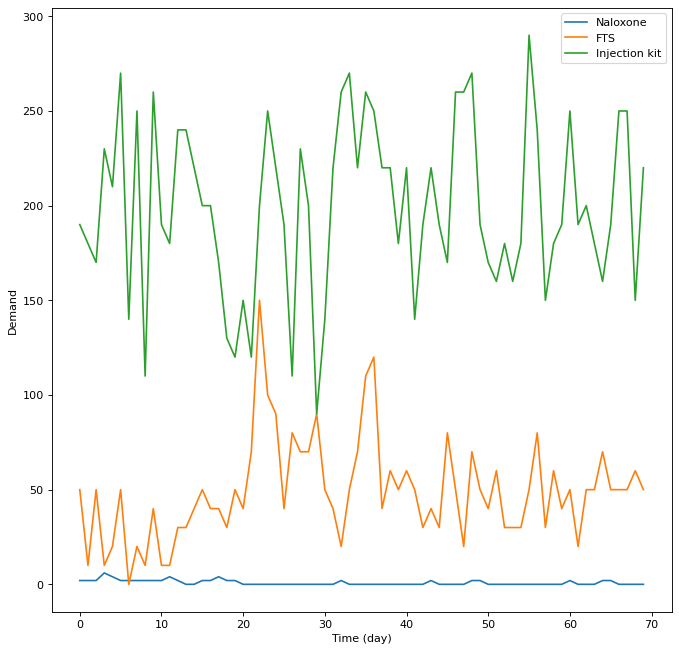

In [57]:
Naloxone_List = []
FTS_List = []
Injection_List = []
for ij in total_daily_demand_list[20::]:
    Naloxone_List.append(ij[0])
    FTS_List.append(ij[1])
    Injection_List.append(ij[2])
plt.figure(figsize=(10,10), dpi=80)
plt.plot( list(np.arange(70)), Naloxone_List)
plt.plot( list(np.arange(70)), FTS_List)
plt.plot( list(np.arange(70)), Injection_List)
plt.legend(['Naloxone', 'FTS', 'Injection kit'])
plt.xlabel('Time (day)')
plt.ylabel('Demand')

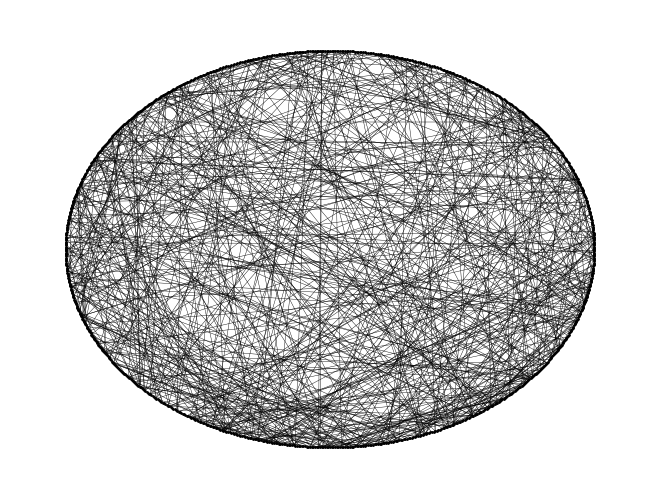

In [11]:
nx.draw_shell(network_all, **{'node_color': 'black', 'node_size': 1,'width': 0.3})

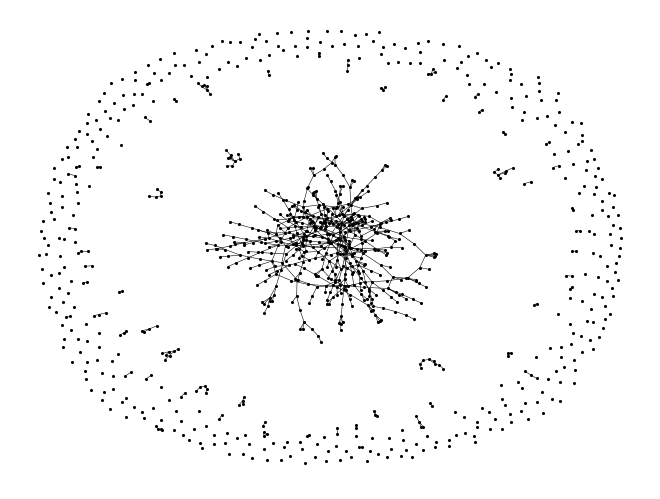

In [12]:
nx.draw(network_all, **{'node_color': 'black', 'node_size': 1.5,'width': 0.4})

# Fentanyl Adultrtion Rate Uncertainty Analysis

In [15]:
def sensitivity_analysis(i):
    
    if i == 0:
        fentanyl_adultrationn_rate = 0
    elif i == 1:
        fentanyl_adultrationn_rate = 0.1
    elif i == 2:
        fentanyl_adultrationn_rate = 0.2
    elif i == 3:
        fentanyl_adultrationn_rate = 0.3
    elif i == 4:
        fentanyl_adultrationn_rate = 0.4
    elif i == 5:
        fentanyl_adultrationn_rate = 0.5
    elif i == 6:
        fentanyl_adultrationn_rate = 0.6
    elif i == 7:
        fentanyl_adultrationn_rate = 0.7
    elif i == 8:
        fentanyl_adultrationn_rate = 0.8
    elif i == 9:
        fentanyl_adultrationn_rate = 0.9
    else: #i=10
        fentanyl_adultrationn_rate = 1

    
    return(fentanyl_adultrationn_rate)

In [ ]:
########################
np.random.seed(1000)   #
random.seed(1000*2)    #
########################
treatment_success_prob = 0

Total_DALYs_list = []
V1_list = []

for i in range(11):
    fentanyl_adultrationn_rate = sensitivity_analysis(i) 

    
    volumes = {'naloxone_kit':0.5, 'FTS':0.1, 'injection_kits':0.1}

    log_results = []
    V0 = [0,0,0]
    V1 = [1/3, 1/3, 1/3]
    OBJS = [0]
    results = []
    sim_num = 1000
    dual_results = []       #2 arrays of sim_num size : [[.....], [.....]]

    # V0
    initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V0,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V0,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
    result = Pool().map(simulation, list(np.arange(sim_num)))
    statistic = result[0]/sim_num
    for stat in result[1:]:
        statistic = statistic + stat/sim_num
    dual_results.append(statistic)
    log_results.append([V0, statistic])
    initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
    result = Pool().map(simulation, list(np.arange(sim_num)))

    statistic = result[0]/sim_num
    for stat in result[1:]:
        statistic = statistic + stat/sim_num
    dual_results.append(statistic)
    log_results.append([V1, statistic])
    
   
    initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
    result = Pool().map(simulation, list(np.arange(sim_num)))

    statistic = result[0]/sim_num
    for stat in result[1:]:
        statistic = statistic + stat/sim_num

    DEMAND_RESULTS = dual_results[1][['VM_log_Naloxone', 'VM_log_FTS', 'VM_log_Injection_kit']]
    DEMAND_RESULTS.rename({'VM_log_Naloxone': 'naloxone_kit', 'VM_log_FTS': 'FTS', 'VM_log_Injection_kit': 'injection_kits'}, axis=1, inplace=True)

    DALY_RESULTS = dual_results[0] - dual_results[1]  
    DALY_RESULTS['OD_experienced'] = DALY_RESULTS['OD_ED_saved'] + DALY_RESULTS['OD_THN_saved']    
    DALY_RESULTS = DALY_RESULTS[['HIV_New_Cases', 'HCV_New_Cases', 'OD_experienced', 'OD_deceased']]
    DALY_RESULTS = DALY_RESULTS * DALYs                                                        
    DALY_RESULTS['HIV_HCV_NewCases'] = DALY_RESULTS['HIV_New_Cases'] + DALY_RESULTS['HCV_New_Cases']
    DALY_RESULTS = DALY_RESULTS[['HIV_HCV_NewCases', 'OD_experienced', 'OD_deceased']] 
    DALY_RESULTS.rename({'HIV_HCV_NewCases': 'injection_kits', 'OD_experienced': 'FTS', 'OD_deceased': 'naloxone_kit'}, axis=1, inplace=True)
    DALY_RESULTS[DALY_RESULTS < 0] = 0
    
#############################################    
    Total_DALYs_list.append(np.sum(np.sum(DALY_RESULTS)))
#############################################
    

    DALY_RESULTS['naloxone_kit'] = DALY_RESULTS['naloxone_kit'] / 0.5
    DALY_RESULTS['FTS'] = DALY_RESULTS['FTS'] / 0.1
    DALY_RESULTS['injection_kits'] = DALY_RESULTS['injection_kits'] / 0.1

    
    DALY_RESULTS = DALY_RESULTS.sort_values(by=0, ascending=False, axis=1)

    allocation = pd.DataFrame(columns=['naloxone_kit', 'FTS', 'injection_kits'], index=range(1)).fillna(0)
    Vk = Tot_Vol
    i = 0
    while Vk > 0:
        if i == 3:
            i = 0
        allocation[DALY_RESULTS.columns[i]] = allocation[DALY_RESULTS.columns[i]] + min(Vk/volumes[DALY_RESULTS.columns[i]], DEMAND_RESULTS[DALY_RESULTS.columns[i]].values) 
        Vk = Vk - volumes[DALY_RESULTS.columns[i]] * min(Vk/volumes[DALY_RESULTS.columns[i]], DEMAND_RESULTS[DALY_RESULTS.columns[i]].values) 
        i = i + 1

    V1 = list(((allocation * volumes)/Tot_Vol).values[0])

    V1_list.append(V1)


In [ ]:
Total_DALYs_list.to_csv('Total_DALYs_list_fts.csv')

In [ ]:
V1_list.to_csv('V1_list_fts.csv')

# MDM REVISION: FENTANYL AS A DRUG OF CHOICE

### Adherence to FTS positive results: 100%

In [9]:
FTS_positive_adherence = 1

In [10]:
def sensitivity_analysis(i):

    if i == 0:
        FTS_utaliztion_rate = 0
        fentanyl_adultrationn_rate = 0
    elif i == 1:
        FTS_utaliztion_rate = 0
        fentanyl_adultrationn_rate = 0.2
    elif i == 2:
        FTS_utaliztion_rate = 0
        fentanyl_adultrationn_rate = 0.4
    elif i == 3:
        FTS_utaliztion_rate = 0
        fentanyl_adultrationn_rate = 0.6
    elif i == 4:
        FTS_utaliztion_rate = 0
        fentanyl_adultrationn_rate = 0.8
    elif i == 5:
        FTS_utaliztion_rate = 0
        fentanyl_adultrationn_rate = 1
    elif i == 6:
        FTS_utaliztion_rate = 0.2
        fentanyl_adultrationn_rate = 0
    elif i == 7:
        FTS_utaliztion_rate = 0.2
        fentanyl_adultrationn_rate = 0.2
    elif i == 8:
        FTS_utaliztion_rate = 0.2
        fentanyl_adultrationn_rate = 0.4
    elif i == 9:
        FTS_utaliztion_rate = 0.2
        fentanyl_adultrationn_rate = 0.6
    elif i == 10:
        FTS_utaliztion_rate = 0.2
        fentanyl_adultrationn_rate = 0.8
    elif i == 11:
        FTS_utaliztion_rate = 0.2
        fentanyl_adultrationn_rate = 1
    elif i == 12:
        FTS_utaliztion_rate = 0.4
        fentanyl_adultrationn_rate = 0
    elif i == 13:
        FTS_utaliztion_rate = 0.4
        fentanyl_adultrationn_rate = 0.2
    elif i == 14:
        FTS_utaliztion_rate = 0.4
        fentanyl_adultrationn_rate = 0.4
    elif i == 15:
        FTS_utaliztion_rate = 0.4
        fentanyl_adultrationn_rate = 0.6
    elif i == 16:
        FTS_utaliztion_rate = 0.4
        fentanyl_adultrationn_rate = 0.8
    elif i == 17:
        FTS_utaliztion_rate = 0.4
        fentanyl_adultrationn_rate = 1
    elif i == 18:
        FTS_utaliztion_rate = 0.6
        fentanyl_adultrationn_rate = 0
    elif i == 19:
        FTS_utaliztion_rate = 0.6
        fentanyl_adultrationn_rate = 0.2
    elif i == 20:
        FTS_utaliztion_rate = 0.6
        fentanyl_adultrationn_rate = 0.4
    elif i == 21:
        FTS_utaliztion_rate = 0.6
        fentanyl_adultrationn_rate = 0.6
    elif i == 22:
        FTS_utaliztion_rate = 0.6
        fentanyl_adultrationn_rate = 0.8
    elif i == 23:
        FTS_utaliztion_rate = 0.6
        fentanyl_adultrationn_rate = 1
    elif i == 24:
        FTS_utaliztion_rate = 0.8
        fentanyl_adultrationn_rate = 0
    elif i == 25:
        FTS_utaliztion_rate = 0.8
        fentanyl_adultrationn_rate = 0.2
    elif i == 26:
        FTS_utaliztion_rate = 0.8
        fentanyl_adultrationn_rate = 0.4
    elif i == 27:
        FTS_utaliztion_rate = 0.8
        fentanyl_adultrationn_rate = 0.6
    elif i == 28:
        FTS_utaliztion_rate = 0.8
        fentanyl_adultrationn_rate = 0.8
    elif i == 29:
        FTS_utaliztion_rate = 0.8
        fentanyl_adultrationn_rate = 1
    elif i == 30:
        FTS_utaliztion_rate = 1
        fentanyl_adultrationn_rate = 0
    elif i == 31:
        FTS_utaliztion_rate = 1
        fentanyl_adultrationn_rate = 0.2
    elif i == 32:
        FTS_utaliztion_rate = 1
        fentanyl_adultrationn_rate = 0.4
    elif i == 33:
        FTS_utaliztion_rate = 1
        fentanyl_adultrationn_rate = 0.6
    elif i == 34:
        FTS_utaliztion_rate = 1
        fentanyl_adultrationn_rate = 0.8
    else: #i = 35
        FTS_utaliztion_rate = 1
        fentanyl_adultrationn_rate = 1

    
    return(fentanyl_adultrationn_rate, FTS_utaliztion_rate)

In [ ]:
########################
np.random.seed(1000)   #
random.seed(1000*2)    #
########################
treatment_success_prob = 0

Total_DALYs_list = []
V1_list = []

volumes = {'naloxone_kit':0.5, 'FTS':0.1, 'injection_kits':0.1}

log_results = []
V0 = [0,0,0]
V1 = [1/3, 1/3, 1/3]
OBJS = [0]
results = []
sim_num = 1000
dual_results = []       #2 arrays of sim_num size : [[.....], [.....]]
        
initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V0,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V0,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
with Pool(processes=24) as pool:
    for i in range(36):
        fentanyl_adultrationn_rate, FTS_utaliztion_rate = sensitivity_analysis(i) 

        volumes = {'naloxone_kit':0.5, 'FTS':0.1, 'injection_kits':0.1}

        log_results = []
        V0 = [0,0,0]
        V1 = [1/3, 1/3, 1/3]
        OBJS = [0]
        results = []
        sim_num = 1000
        dual_results = []       #2 arrays of sim_num size : [[.....], [.....]]
        
        # V0
        initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V0,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V0,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
        result = pool.map(simulation, list(np.arange(sim_num)), chunksize=50)
        
        statistic = result[0]/sim_num
        for stat in result[1:]:
            statistic = statistic + stat/sim_num
        dual_results.append(statistic)
        log_results.append([V0, statistic])
        
        initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
        result = pool.map(simulation, list(np.arange(sim_num)), chunksize=50)

        statistic = result[0]/sim_num
        for stat in result[1:]:
            statistic = statistic + stat/sim_num
        dual_results.append(statistic)
        log_results.append([V1, statistic])

        initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
        result = pool.map(simulation, list(np.arange(sim_num)), chunksize=50)

        statistic = result[0]/sim_num
        for stat in result[1:]:
            statistic = statistic + stat/sim_num

        DEMAND_RESULTS = dual_results[1][['VM_log_Naloxone', 'VM_log_FTS', 'VM_log_Injection_kit']]
        DEMAND_RESULTS.rename({'VM_log_Naloxone': 'naloxone_kit', 'VM_log_FTS': 'FTS', 'VM_log_Injection_kit': 'injection_kits'}, axis=1, inplace=True)

        DALY_RESULTS = dual_results[0] - dual_results[1]  
        DALY_RESULTS['OD_experienced'] = DALY_RESULTS['OD_ED_saved'] + DALY_RESULTS['OD_THN_saved']    
        DALY_RESULTS = DALY_RESULTS[['HIV_New_Cases', 'HCV_New_Cases', 'OD_experienced', 'OD_deceased']]
        DALY_RESULTS = DALY_RESULTS * DALYs                                                        
        DALY_RESULTS['HIV_HCV_NewCases'] = DALY_RESULTS['HIV_New_Cases'] + DALY_RESULTS['HCV_New_Cases']
        DALY_RESULTS = DALY_RESULTS[['HIV_HCV_NewCases', 'OD_experienced', 'OD_deceased']] 
        DALY_RESULTS.rename({'HIV_HCV_NewCases': 'injection_kits', 'OD_experienced': 'FTS', 'OD_deceased': 'naloxone_kit'}, axis=1, inplace=True)
        DALY_RESULTS[DALY_RESULTS < 0] = 0

    #############################################    
        Total_DALYs_list.append(np.sum(np.sum(DALY_RESULTS)))
        pd.Series(Total_DALYs_list).to_csv('Total_DALYs_list_{}.csv'.format(i))
    #############################################


        DALY_RESULTS['naloxone_kit'] = DALY_RESULTS['naloxone_kit'] / 0.5
        DALY_RESULTS['FTS'] = DALY_RESULTS['FTS'] / 0.1
        DALY_RESULTS['injection_kits'] = DALY_RESULTS['injection_kits'] / 0.1


        DALY_RESULTS = DALY_RESULTS.sort_values(by=0, ascending=False, axis=1)

        allocation = pd.DataFrame(columns=['naloxone_kit', 'FTS', 'injection_kits'], index=range(1)).fillna(0)
        Vk = Tot_Vol
        i = 0
        while Vk > 0:
            if i == 3:
                i = 0
            allocation[DALY_RESULTS.columns[i]] = allocation[DALY_RESULTS.columns[i]] + min(Vk/volumes[DALY_RESULTS.columns[i]], DEMAND_RESULTS[DALY_RESULTS.columns[i]].values) 
            Vk = Vk - volumes[DALY_RESULTS.columns[i]] * min(Vk/volumes[DALY_RESULTS.columns[i]], DEMAND_RESULTS[DALY_RESULTS.columns[i]].values) 
            i = i + 1

        V1 = list(((allocation * volumes)/Tot_Vol).values[0])

        V1_list.append(V1)
        pd.Series(V1_list).to_csv('V1_list_{}.csv'.format(i))
        
        
pd.Series(Total_DALYs_list).to_csv('Total_DALYs_list_fts_MDM.csv')
pd.Series(V1_list).to_csv('V1_list_fts_MDM.csv')

In [ ]:
########################
np.random.seed(1000)   #
random.seed(1000*2)    #
########################
treatment_success_prob = 0

Total_DALYs_list = []
V1_list = []

for i in range(36):
    fentanyl_adultrationn_rate, FTS_utaliztion_rate = sensitivity_analysis(i) 

    
    volumes = {'naloxone_kit':0.5, 'FTS':0.1, 'injection_kits':0.1}

    log_results = []
    V0 = [0,0,0]
    V1 = [1/3, 1/3, 1/3]
    OBJS = [0]
    results = []
    sim_num = 1000
    dual_results = []       #2 arrays of sim_num size : [[.....], [.....]]
    # V0
    initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V0,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V0,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
    result = Pool().map(simulation, list(np.arange(sim_num)))
    statistic = result[0]/sim_num
    for stat in result[1:]:
        statistic = statistic + stat/sim_num
    dual_results.append(statistic)
    log_results.append([V0, statistic])
    initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
    result = Pool().map(simulation, list(np.arange(sim_num)))

    statistic = result[0]/sim_num
    for stat in result[1:]:
        statistic = statistic + stat/sim_num
    dual_results.append(statistic)
    log_results.append([V1, statistic])
   
    initial_compartments_table = np.array([list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))), np.array(list(np.multiply(np.floor(np.multiply(V1,[Tot_Vol,Tot_Vol,Tot_Vol])),np.array([2,10,10]))))]).transpose()
    result = Pool().map(simulation, list(np.arange(sim_num)))

    statistic = result[0]/sim_num
    for stat in result[1:]:
        statistic = statistic + stat/sim_num

    DEMAND_RESULTS = dual_results[1][['VM_log_Naloxone', 'VM_log_FTS', 'VM_log_Injection_kit']]
    DEMAND_RESULTS.rename({'VM_log_Naloxone': 'naloxone_kit', 'VM_log_FTS': 'FTS', 'VM_log_Injection_kit': 'injection_kits'}, axis=1, inplace=True)

    DALY_RESULTS = dual_results[0] - dual_results[1]  
    DALY_RESULTS['OD_experienced'] = DALY_RESULTS['OD_ED_saved'] + DALY_RESULTS['OD_THN_saved']    
    DALY_RESULTS = DALY_RESULTS[['HIV_New_Cases', 'HCV_New_Cases', 'OD_experienced', 'OD_deceased']]
    DALY_RESULTS = DALY_RESULTS * DALYs                                                        
    DALY_RESULTS['HIV_HCV_NewCases'] = DALY_RESULTS['HIV_New_Cases'] + DALY_RESULTS['HCV_New_Cases']
    DALY_RESULTS = DALY_RESULTS[['HIV_HCV_NewCases', 'OD_experienced', 'OD_deceased']] 
    DALY_RESULTS.rename({'HIV_HCV_NewCases': 'injection_kits', 'OD_experienced': 'FTS', 'OD_deceased': 'naloxone_kit'}, axis=1, inplace=True)
    DALY_RESULTS[DALY_RESULTS < 0] = 0
    
#############################################    
    Total_DALYs_list.append(np.sum(np.sum(DALY_RESULTS)))
    pd.Series(Total_DALYs_list).to_csv('Total_DALYs_list_PoolOriginal.csv')
#############################################
    

    DALY_RESULTS['naloxone_kit'] = DALY_RESULTS['naloxone_kit'] / 0.5
    DALY_RESULTS['FTS'] = DALY_RESULTS['FTS'] / 0.1
    DALY_RESULTS['injection_kits'] = DALY_RESULTS['injection_kits'] / 0.1

    
    DALY_RESULTS = DALY_RESULTS.sort_values(by=0, ascending=False, axis=1)

    allocation = pd.DataFrame(columns=['naloxone_kit', 'FTS', 'injection_kits'], index=range(1)).fillna(0)
    Vk = Tot_Vol
    i = 0
    while Vk > 0:
        if i == 3:
            i = 0
        allocation[DALY_RESULTS.columns[i]] = allocation[DALY_RESULTS.columns[i]] + min(Vk/volumes[DALY_RESULTS.columns[i]], DEMAND_RESULTS[DALY_RESULTS.columns[i]].values) 
        Vk = Vk - volumes[DALY_RESULTS.columns[i]] * min(Vk/volumes[DALY_RESULTS.columns[i]], DEMAND_RESULTS[DALY_RESULTS.columns[i]].values) 
        i = i + 1

    V1 = list(((allocation * volumes)/Tot_Vol).values[0])

    V1_list.append(V1)
    pd.Series(V1_list).to_csv('V1_list_PoolOriginal.csv')


/tmp/ipykernel_2930828/3908762942.py:5: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed*2)
/tmp/ipykernel_2930828/3908762942.py:5: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed*2)
/tmp/ipykernel_2930828/3908762942.py:5: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed*2)
/tmp/ipykernel_2930828/3908762942.py:5: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, 

Working directory: /storage/work/rzz5164/SUD problem
Files in directory: ['.ipynb_checkpoints', 'Cusum eGFRV.ipynb', 'Normal and ESKD group data.ipynb', 'SUD ABM V 0.0.ipynb', 'SUD ABM V 3.0.ipynb', 'SUD ABM V 3.1.ipynb', 'SUD ABM V 4.0 - numpy.ipynb', 'SUD ABM V 4.1.ipynb', 'SUD ABM V 5.0 - greedy.ipynb', 'SUD ABM V 5.1 - initial demand updated.ipynb', 'SUD ABM V 6.0 - Grid search 2.ipynb', 'SUD ABM V 6.0 - Grid search.ipynb', 'SUD ABM V 6.0 - Scenario 1.ipynb', 'SUD ABM V 6.0 - Scenario 2.ipynb', 'SUD ABM V 6.0 - Scenario 3.ipynb', 'SUD ABM V 6.0 - Scenario 4.ipynb', 'SUD ABM V 6.0 - Scenario 5 - Harvard-2025.ipynb', 'SUD ABM V 6.0 - Scenario 5 - Harvard-Copy1.ipynb', 'SUD ABM V 6.0 - Scenario 5 - Harvard-Copy2.ipynb', 'SUD ABM V 6.0 - Scenario 5 - Harvard.ipynb', 'SUD ABM V 6.0 - Sensitivity analysis - 1-Copy1.ipynb', 'SUD ABM V 6.0 - Sensitivity analysis - 1.ipynb', 'SUD ABM V 6.0 - Sensitivity analysis - 2.ipynb', 'Total_DALYs_list_PoolOriginal.csv', 'V1_list_PoolOriginal.csv', 'n

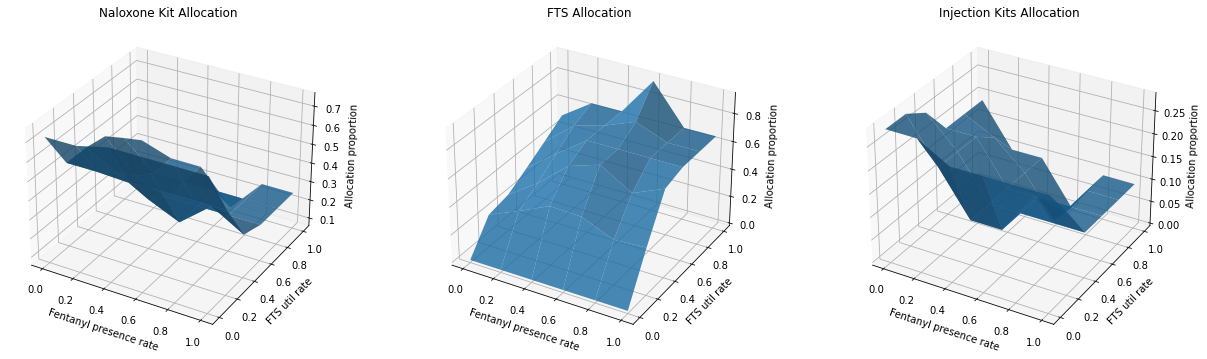

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Show current working directory and files to confirm paths
print("Working directory:", os.getcwd())
print("Files in directory:", os.listdir())

# Load the CSVs (expecting them in current directory)
dalys_raw = pd.read_csv('Total_DALYs_list_PoolOriginal.csv', header=None, skiprows=1)
v1_raw   = pd.read_csv('V1_list_PoolOriginal.csv',         header=None, skiprows=1)

# Parse allocation proportions
v1_parsed = (
    v1_raw.iloc[:, 1]
    .str.strip('"[]')
    .str.split(',', expand=True)
    .astype(float)
)
v1_parsed.columns = ['naloxone_kit', 'FTS', 'injection_kits']

# Build parameter grids
levels = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
fentanyl_rate = np.array([levels[i % 6] for i in range(len(v1_parsed))])
FTS_util_rate = np.array([levels[i // 6] for i in range(len(v1_parsed))])

# Reshape to 6x6
X = fentanyl_rate.reshape(6, 6)
Y = FTS_util_rate.reshape(6, 6)
Z_nal = v1_parsed['naloxone_kit'].values.reshape(6, 6)
Z_fts = v1_parsed['FTS'].values.reshape(6, 6)
Z_inj = v1_parsed['injection_kits'].values.reshape(6, 6)

# 3D surface plots
fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X, Y, Z_nal, rstride=1, cstride=1, edgecolor='none', alpha=0.8)
ax1.set_title('Naloxone Kit Allocation')
ax1.set_xlabel('Fentanyl presence rate')
ax1.set_ylabel('FTS util rate')
ax1.set_zlabel('Allocation proportion')

ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X, Y, Z_fts, rstride=1, cstride=1, edgecolor='none', alpha=0.8)
ax2.set_title('FTS Allocation')
ax2.set_xlabel('Fentanyl presence rate')
ax2.set_ylabel('FTS util rate')
ax2.set_zlabel('Allocation proportion')

ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X, Y, Z_inj, rstride=1, cstride=1, edgecolor='none', alpha=0.8)
ax3.set_title('Injection Kits Allocation')
ax3.set_xlabel('Fentanyl presence rate')
ax3.set_ylabel('FTS util rate')
ax3.set_zlabel('Allocation proportion')

plt.tight_layout()
plt.show()


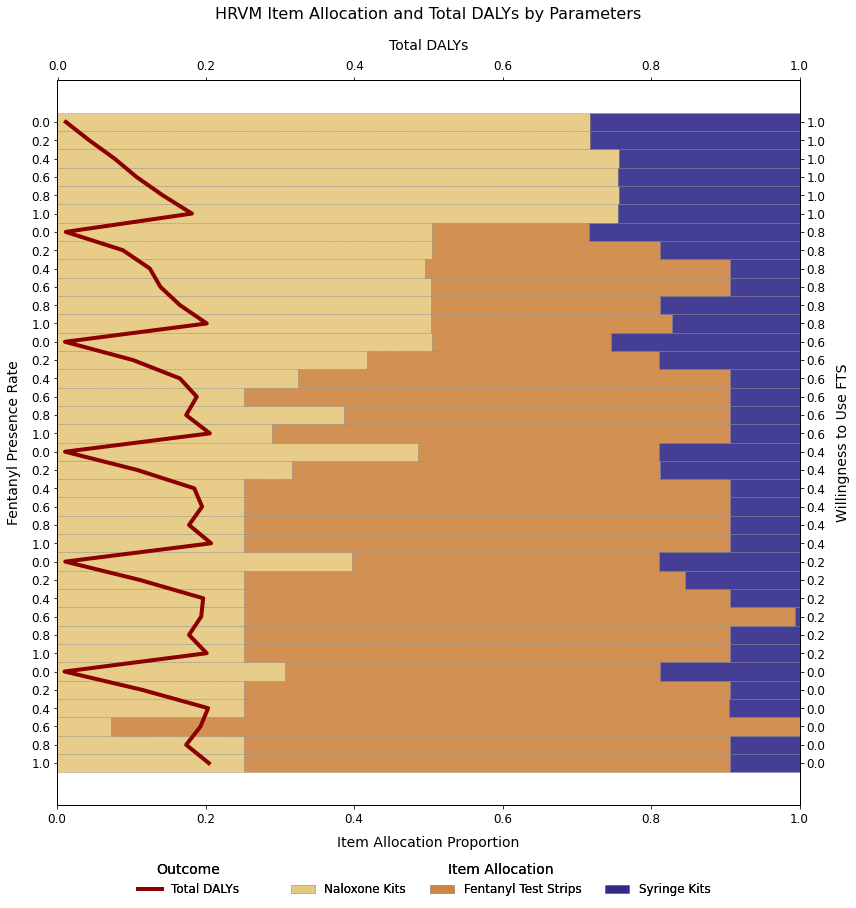

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Sensitivity grid mapping
def sensitivity_analysis(i):
    levels = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    return levels[i % 6], levels[i // 6]  # fentanyl_rate, FTS_util_rate

# Load allocation proportions
v1_raw = pd.read_csv('V1_list_PoolOriginal.csv', header=None, skiprows=1)
alloc = (v1_raw.iloc[:, 1]
         .str.strip('"[]')
         .str.split(',', expand=True)
         .astype(float))
alloc.columns = ['Naloxone Kits', 'Fentanyl Test Strips', 'Syringe Kits']

# Load DALYs
dalys_raw = pd.read_csv('Total_DALYs_list_PoolOriginal.csv', header=None, skiprows=1)
dalys = dalys_raw.iloc[:, 1].astype(float).values

# Build DataFrame
df = alloc.copy()
df['fentanyl_rate'], df['FTS_util_rate'] = zip(*[sensitivity_analysis(i) for i in df.index])
df['Total_DALYs'] = dalys

# Sort for coherent ordering
df_sorted = df.sort_values(['FTS_util_rate', 'fentanyl_rate']).reset_index(drop=True)

# Prepare y positions and parameter values
y = np.arange(len(df_sorted))
fent_vals = df_sorted['fentanyl_rate'].values
fts_vals   = df_sorted['FTS_util_rate'].values
dalys_sorted = df_sorted['Total_DALYs'].values

# Colors matching palette
colors = ['#E6C87D', 'peru', '#2F2A8A']

# Plot horizontal stacked bars
fig, ax = plt.subplots(figsize=(12, 12))
left = np.zeros(len(df_sorted))
bars = []
for item, color in zip(['Naloxone Kits', 'Fentanyl Test Strips', 'Syringe Kits'], colors):
    bar = ax.barh(y, df_sorted[item], left=left,
                  color=color, edgecolor='gray', linestyle='--', linewidth=0.5, alpha=0.9,
                  height=1.0, align='center')
    bars.append(bar)
    left += df_sorted[item].values

# Primary x- and y-axis
ax.set_xlim(0, 1)
ax.set_xlabel('Item Allocation Proportion', fontsize=14, labelpad=10)
ax.set_ylabel('Fentanyl Presence Rate', fontsize=14, labelpad=10)
ax.set_yticks(y)
ax.set_yticklabels(fent_vals, fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.invert_yaxis()

# Secondary y-axis for FTS utilization rate
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(y)
ax2.set_yticklabels(fts_vals, fontsize=12)
ax2.tick_params(axis='x', labelsize=12)
ax2.set_ylabel('Willingness to Use FTS', fontsize=14, labelpad=10)
ax2.invert_yaxis()

# Top x-axis for actual Total DALYs
ax_top = ax.twiny()
line = ax_top.plot(dalys_sorted, y, color='darkred', linewidth=4)[0]
ax_top.set_xlabel('Total DALYs', fontsize=14, labelpad=10)
ax_top.set_xticks(np.linspace(0, 1, 6))
ax_top.tick_params(axis='x', labelsize=12)

# Legend for item allocations at bottom center
item_legend = ax.legend(bars,
                        ['Naloxone Kits', 'Fentanyl Test Strips', 'Syringe Kits'],
                        loc='lower right',
                        bbox_to_anchor=(0.895, -0.14),
                        ncol=3,
                        frameon=False,
                        fontsize=12,
                        title='Item Allocation',title_fontsize=14)

# Separate legend for Total DALYs on the top axis
dalys_legend = ax_top.legend([line], ['Total DALYs'],
                             loc='lower right',
                             bbox_to_anchor=(0.26, -0.14),
                             frameon=False,
                             fontsize=12,
                             title='Outcome',title_fontsize=14)

# Add legends to the axes
ax.add_artist(item_legend)
ax_top.add_artist(dalys_legend)

plt.savefig('plot_4_MDM_revised.jpg', orientation="landscape",
           dpi=300)

plt.title('HRVM Item Allocation and Total DALYs by Parameters', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


/tmp/ipykernel_1040977/3899626114.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


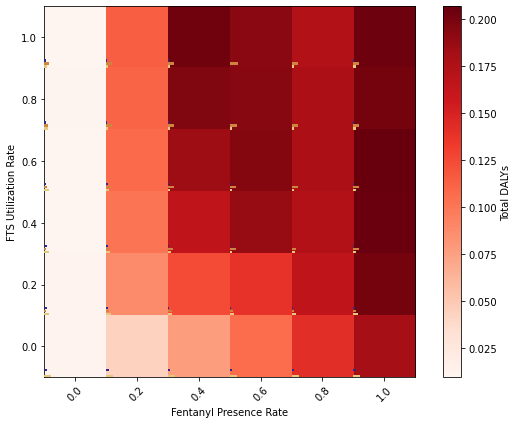

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 1) Load & prepare your DataFrame exactly as before…
v1_raw = pd.read_csv('V1_list_PoolOriginal.csv', header=None, skiprows=1)
alloc = (v1_raw.iloc[:,1]
         .str.strip('"[]')
         .str.split(',', expand=True)
         .astype(float))
alloc.columns = ['Naloxone Kits','Fentanyl Test Strips','Syringe Kits']

dalys_raw = pd.read_csv('Total_DALYs_list_PoolOriginal.csv', header=None, skiprows=1)
dalys = dalys_raw.iloc[:,1].astype(float).values

def sensitivity_analysis(i):
    levels = [0,0.2,0.4,0.6,0.8,1.0]
    return levels[i%6], levels[i//6]

df = alloc.copy()
df['fentanyl_rate'], df['FTS_util_rate'] = zip(*[sensitivity_analysis(i) for i in df.index])
df['Total_DALYs'] = dalys

# 2) Pivot into a 6×6 grid for the heatmap
heatmap = df.pivot(index='FTS_util_rate', columns='fentanyl_rate', values='Total_DALYs')
fent_levels = heatmap.columns.values
fts_levels  = heatmap.index.values

fig, ax = plt.subplots(figsize=(8,6))

# 3) Draw the heatmap
im = ax.imshow(heatmap.values,
               origin='lower',
               cmap='Reds',
               aspect='equal')

# 4) Ticks & colorbar
ax.set_xticks(np.arange(len(fent_levels)))
ax.set_xticklabels(fent_levels, rotation=45)
ax.set_yticks(np.arange(len(fts_levels)))
ax.set_yticklabels(fts_levels)
ax.set_xlabel('Fentanyl Presence Rate')
ax.set_ylabel('FTS Utilization Rate')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Total DALYs')

# 5) Embed a tiny bar chart in each cell
for i, fts in enumerate(fts_levels):
    for j, fent in enumerate(fent_levels):
        row = df[(df['FTS_util_rate']==fts)&(df['fentanyl_rate']==fent)]
        if row.empty: 
            continue
        vals = row[['Naloxone Kits','Fentanyl Test Strips','Syringe Kits']].iloc[0].values
        
        # place inset axes in the correct grid‐cell
        axins = inset_axes(ax,
                           width="15%", height="15%",   # tweak size as needed
                           loc='lower left',
                           bbox_to_anchor=(j/6, i/6, 1/6, 1/6),
                           bbox_transform=ax.transAxes,
                           borderpad=0)
        
        # horizontal bars
        axins.barh([0,1,2], vals, 
                   color=['#E6C87D','peru','#2F2A8A'], 
                   edgecolor='none')
        axins.set_xlim(0,1)
        axins.axis('off')

plt.tight_layout()
plt.show()
